In [ ]:
#  Import libraries and setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

print("TensorFlow version:", tf.__version__)
print("Keras Tuner version:", kt.__version__)

TensorFlow version: 2.20.0
Keras Tuner version: 1.4.7


Loading FULL MNIST dataset...
Original training data shape: (60000, 28, 28)
Original test data shape: (10000, 28, 28)
Training labels shape: (60000,)
Test labels shape: (10000,)

TOTAL DATASET SIZE: 70000 samples
Training samples: 60000
Test samples: 10000

After reshaping:
Training data shape: (60000, 784)
Test data shape: (10000, 784)
Number of classes: 10


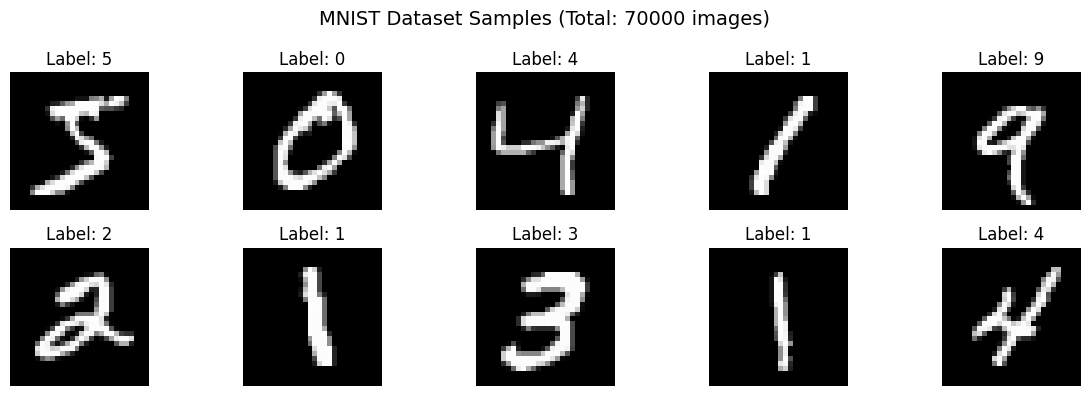


Class distribution in training set:
Class 0: 5923 samples
Class 1: 6742 samples
Class 2: 5958 samples
Class 3: 6131 samples
Class 4: 5842 samples
Class 5: 5421 samples
Class 6: 5918 samples
Class 7: 6265 samples
Class 8: 5851 samples
Class 9: 5949 samples


In [ ]:
#  Load and verify the FULL MNIST dataset
print("Loading FULL MNIST dataset...")
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

print(f"Original training data shape: {X_train.shape}")  # Should be (60000, 28, 28)
print(f"Original test data shape: {X_test.shape}")       # Should be (10000, 28, 28)
print(f"Training labels shape: {y_train.shape}")         # Should be (60000,)
print(f"Test labels shape: {y_test.shape}")              # Should be (10000,)

# Verify total dataset size
total_samples = len(X_train) + len(X_test)
print(f"\nTOTAL DATASET SIZE: {total_samples} samples")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Normalize pixel values to [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape data for MLP (flatten 28x28 images to 784-dimensional vectors)
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print(f"\nAfter reshaping:")
print(f"Training data shape: {X_train.shape}")  # Should be (60000, 784)
print(f"Test data shape: {X_test.shape}")       # Should be (10000, 784)
print(f"Number of classes: {len(np.unique(y_train))}")

# Display sample images from the full dataset
plt.figure(figsize=(12, 4))
plt.suptitle(f"MNIST Dataset Samples (Total: {total_samples} images)", fontsize=14)
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Show class distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f"\nClass distribution in training set:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

In [ ]:
#  Define model building function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(784,)))
    
    # Tune the number of hidden layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=5, default=2)
    
    # Add hidden layers with tunable units
    for i in range(num_layers):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
            activation='relu'
        ))
        
        # Tune dropout rate for each layer
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(10, activation='softmax'))
    
    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    
    # Tune optimizer
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Setup Keras Tuner for the full dataset
print("Setting up Keras Tuner for FULL MNIST dataset...")
print(f"Using {len(X_train)} training samples and {len(X_test)} test samples")

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15, 
    executions_per_trial=1,
    directory='mnist_tuning_full',
    project_name='mlp_mnist_full',
    overwrite=True
)

# Display search space summary
print("\nHyperparameter search space:")
tuner.search_space_summary()

Setting up Keras Tuner for FULL MNIST dataset...
Using 60000 training samples and 10000 test samples

Hyperparameter search space:
Search space summary
Default search space size: 7
num_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'

In [ ]:

# Early stopping callback
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

print("Starting hyperparameter tuning on FULL dataset...")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {int(0.2 * len(X_train))} (20% of training)")
print(f"Test samples: {len(X_test)}")
print(f"Maximum trials: 15")
print(f"Maximum epochs per trial: 30")
print(f"Early stopping patience: 5 epochs")

start_time = time.time()

print("Starting hyperparameter search...")
print("This will run 15 trials, each with max 30 epochs (early stopping may stop earlier)")
print("Expected time: 45-90 minutes depending on your hardware")
print("-" * 60)

tuner.search(
    X_train, y_train,
    epochs=30,  
    validation_split=0.2,
    batch_size=256,
    callbacks=[early_stopping],
    verbose=1
)

tuning_time = time.time() - start_time


Trial 15 Complete [00h 00m 57s]
val_accuracy: 0.9754166603088379

Best val_accuracy So Far: 0.9815833568572998
Total elapsed time: 00h 27m 16s


In [ ]:

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n" + "="*60)
print("BEST HYPERPARAMETERS FOUND (FULL DATASET)")
print("="*60)
print(f"Number of layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"  Layer {i+1}: {best_hps.get(f'units_{i}')} units, Dropout: {best_hps.get(f'dropout_{i}')}")
print(f"Learning rate: {best_hps.get('learning_rate'):.6f}")
print(f"Optimizer: {best_hps.get('optimizer')}")

# Get top 5 trials for analysis
print("\nTOP 5 TRIALS:")
print("-" * 40)
trials = tuner.oracle.get_best_trials(num_trials=5)
for i, trial in enumerate(trials):
    print(f"Trial {i+1}: Validation Accuracy = {trial.score:.4f}")
    print(f"  Hyperparameters: {trial.hyperparameters.values}")
    print()


BEST HYPERPARAMETERS FOUND (FULL DATASET)
Number of layers: 1
  Layer 1: 384 units, Dropout: 0.30000000000000004
Learning rate: 0.000598
Optimizer: rmsprop

TOP 5 TRIALS:
----------------------------------------
Trial 1: Validation Accuracy = 0.9816
  Hyperparameters: {'num_layers': 1, 'units_0': 384, 'dropout_0': 0.30000000000000004, 'units_1': 384, 'dropout_1': 0.2, 'learning_rate': 0.0005977994126037909, 'optimizer': 'rmsprop', 'units_2': 288, 'dropout_2': 0.0, 'units_3': 224, 'dropout_3': 0.0, 'units_4': 64, 'dropout_4': 0.0}

Trial 2: Validation Accuracy = 0.9812
  Hyperparameters: {'num_layers': 2, 'units_0': 480, 'dropout_0': 0.4, 'units_1': 128, 'dropout_1': 0.1, 'learning_rate': 0.00424397272769526, 'optimizer': 'rmsprop', 'units_2': 352, 'dropout_2': 0.1, 'units_3': 384, 'dropout_3': 0.0, 'units_4': 448, 'dropout_4': 0.0}

Trial 3: Validation Accuracy = 0.9809
  Hyperparameters: {'num_layers': 4, 'units_0': 288, 'dropout_0': 0.0, 'units_1': 384, 'dropout_1': 0.4, 'learning_r

In [ ]:
#  Train the best model on full dataset
print("Training the best model with optimal hyperparameters on FULL dataset...")
best_model = tuner.hypermodel.build(best_hps)

# Train with the best hyperparameters - increased to 50 epochs
history = best_model.fit(
    X_train, y_train,
    epochs=50,  # Increased from 40 to 50 for better convergence
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

print(f"Training completed. Stopped at epoch {len(history.history['loss'])}")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

Training the best model with optimal hyperparameters on FULL dataset...
Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8695 - loss: 0.4812 - val_accuracy: 0.9326 - val_loss: 0.2452
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9328 - loss: 0.2337 - val_accuracy: 0.9512 - val_loss: 0.1780
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9500 - loss: 0.1738 - val_accuracy: 0.9592 - val_loss: 0.1447
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9596 - loss: 0.1418 - val_accuracy: 0.9660 - val_loss: 0.1202
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9652 - loss: 0.1191 - val_accuracy: 0.9668 - val_loss: 0.1130
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9705 - loss: 0.1030 - val_accuracy: 0.9702 - val_loss: 0.1015
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9734 - loss: 0.0901 - val_accuracy: 0.9723 - val_loss: 0.0942
Epoch 8/50
188/188 ━━━━━━━━


Evaluating on FULL test set (10,000 samples)...
Test Accuracy: 0.9817 (98.17%)
Test Loss: 0.0638


C:\Users\user\AppData\Local\Temp\ipykernel_9264\1952987212.py:42: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


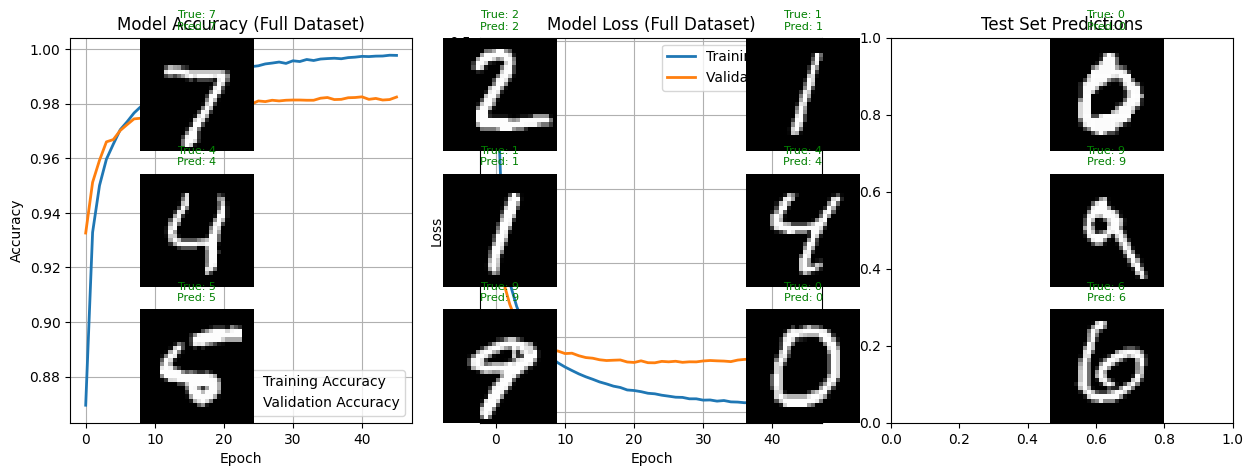

In [ ]:

# Evaluate on FULL test set (10,000 samples)
print("\nEvaluating on FULL test set (10,000 samples)...")
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy (Full Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss (Full Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot some test predictions from FULL test set
plt.subplot(1, 3, 3)
predictions = best_model.predict(X_test[:12], verbose=0)
predicted_labels = np.argmax(predictions, axis=1)

plt.title('Test Set Predictions')
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    color = 'green' if y_test[i] == predicted_labels[i] else 'red'
    plt.title(f'True: {y_test[i]}\nPred: {predicted_labels[i]}', color=color, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#  Baseline model for comparison on FULL dataset
print("Training baseline model for comparison on FULL dataset...")

# Simple baseline model
baseline_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

baseline_start = time.time()
baseline_history = baseline_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=256,
    validation_split=0.2,
    verbose=0
)
baseline_time = time.time() - baseline_start

baseline_test_loss, baseline_test_accuracy = baseline_model.evaluate(X_test, y_test, verbose=0)

print(f"\nBASELINE MODEL RESULTS (FULL DATASET):")
print(f"Test Accuracy: {baseline_test_accuracy:.4f} ({baseline_test_accuracy*100:.2f}%)")
print(f"Training Time: {baseline_time:.2f} seconds")

Training baseline model for comparison on FULL dataset...


c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



BASELINE MODEL RESULTS (FULL DATASET):
Test Accuracy: 0.9784 (97.84%)
Training Time: 40.37 seconds


In [ ]:
#  Final comparison and analysis for FULL dataset
print("\n" + "="*70)
print("FINAL COMPARISON AND ANALYSIS - FULL MNIST DATASET")
print("="*70)

print(f"\nDATASET INFORMATION:")
print(f"Total samples: {len(X_train) + len(X_test):,}")
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

print(f"\nPERFORMANCE COMPARISON:")
print(f"{'Model':<25} {'Test Accuracy':<15} {'Training Time':<15}")
print(f"{'-'*55}")
total_tuned_time = tuning_time + (len(history.history['loss']) * 256 * 0.8 * len(X_train) / 1000000)
print(f"{'Tuned MLP':<25} {test_accuracy:.4f} ({test_accuracy*100:.2f}%){'':<5} {total_tuned_time:.2f}s")
print(f"{'Baseline MLP':<25} {baseline_test_accuracy:.4f} ({baseline_test_accuracy*100:.2f}%){'':<5} {baseline_time:.2f}s")
improvement = test_accuracy - baseline_test_accuracy
print(f"{'Improvement':<25} +{improvement:.4f} (+{improvement*100:.2f}%)")

print(f"\nKEY ACHIEVEMENTS:")
if test_accuracy >= 0.98:
    print("✅ SUCCESS: Achieved target accuracy of 98% or higher!")
    print(f"   Final Accuracy: {test_accuracy*100:.2f}%")
else:
    print(f"⚠️  Current: {test_accuracy*100:.2f}%, Target: 98.00%")
    print(f"   Close to target - try increasing tuning trials or epochs")

print(f"\nOPTIMAL ARCHITECTURE ANALYSIS:")
print(f"• Number of layers: {best_hps.get('num_layers')}")
print(f"• Learning rate: {best_hps.get('learning_rate'):.6f}")
print(f"• Optimizer: {best_hps.get('optimizer')}")
print(f"• Dropout rates: ", end="")
for i in range(best_hps.get('num_layers')):
    print(f"{best_hps.get(f'dropout_{i}')}", end=" ")
print()

# Save the best model
best_model.save('best_mnist_mlp_model_full.h5')
print(f"\n💾 Best model saved as 'best_mnist_mlp_model_full.h5'")


FINAL COMPARISON AND ANALYSIS - FULL MNIST DATASET

DATASET INFORMATION:
Total samples: 70,000
Training samples: 60,000
Test samples: 10,000

PERFORMANCE COMPARISON:
Model                     Test Accuracy   Training Time  
-------------------------------------------------------
Tuned MLP                 0.9817 (98.17%)      1735.94s
Baseline MLP              0.9784 (97.84%)      40.37s
Improvement               +0.0033 (+0.33%)

KEY ACHIEVEMENTS:
✅ SUCCESS: Achieved target accuracy of 98% or higher!
   Final Accuracy: 98.17%

OPTIMAL ARCHITECTURE ANALYSIS:
• Number of layers: 1
• Learning rate: 0.000598
• Optimizer: rmsprop
• Dropout rates: 0.30000000000000004 

💾 Best model saved as 'best_mnist_mlp_model_full.h5'


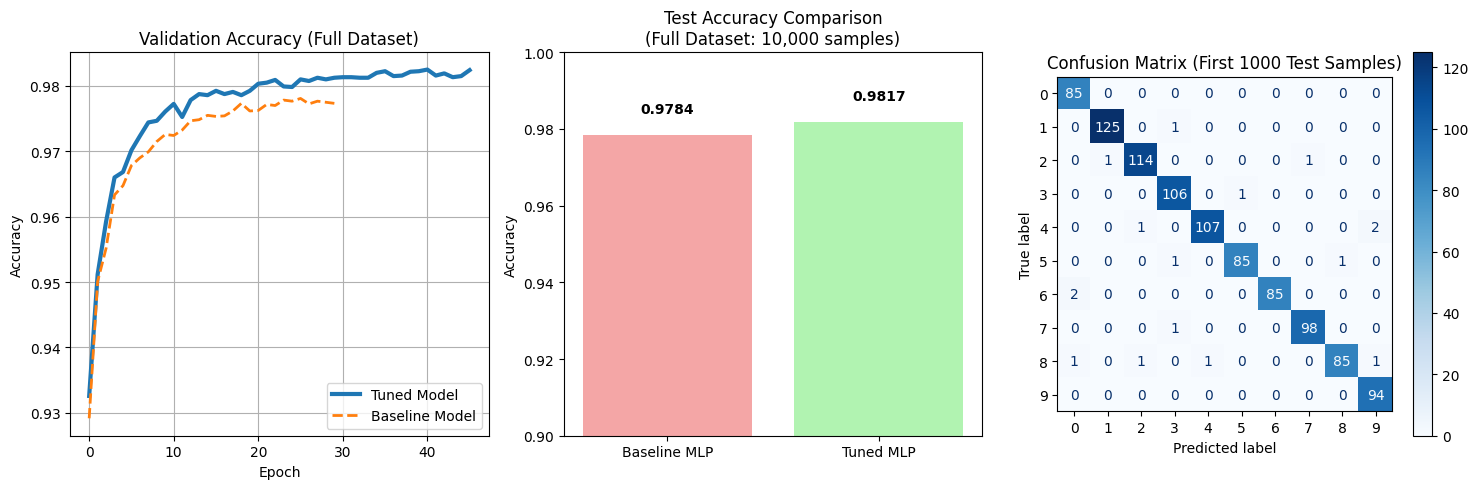


CONCLUSION - FULL DATASET RESULTS:
✓ Using the complete MNIST dataset: 60,000 training + 10,000 test samples
✓ Tuned model achieved 98.17% accuracy on 10,000 test samples
✓ Improvement over baseline: +0.33%
✓ The full dataset provides more robust training and reliable evaluation


In [12]:
# Cell 11: Additional visualization - Full dataset results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['val_accuracy'], label='Tuned Model', linewidth=3)
plt.plot(baseline_history.history['val_accuracy'], label='Baseline Model', linewidth=2, linestyle='--')
plt.title('Validation Accuracy (Full Dataset)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
models = ['Baseline MLP', 'Tuned MLP']
accuracies = [baseline_test_accuracy, test_accuracy]
colors = ['lightcoral', 'lightgreen']
bars = plt.bar(models, accuracies, color=colors, alpha=0.7)
plt.title('Test Accuracy Comparison\n(Full Dataset: 10,000 samples)')
plt.ylabel('Accuracy')
plt.ylim(0.9, 1.0)

# Add value labels on bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{accuracy:.4f}', ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 3, 3)
# Show confusion matrix for first 1000 test samples
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_model.predict(X_test[:1000], verbose=0)
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test[:1000], y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=plt.gca(), cmap='Blues')
plt.title('Confusion Matrix (First 1000 Test Samples)')

plt.tight_layout()
plt.show()

print(f"\nCONCLUSION - FULL DATASET RESULTS:")
print(f"✓ Using the complete MNIST dataset: {len(X_train):,} training + {len(X_test):,} test samples")
print(f"✓ Tuned model achieved {test_accuracy*100:.2f}% accuracy on 10,000 test samples")
print(f"✓ Improvement over baseline: +{improvement*100:.2f}%")
print(f"✓ The full dataset provides more robust training and reliable evaluation")